## Step 1: Upload the libraries.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

# Causal libraries (suppress duecredit warning)
try:
    from io import StringIO
    original_stderr = sys.stderr
    sys.stderr = StringIO()  # Temporarily suppress stderr
    from causalml.inference.tree import UpliftRandomForestClassifier
    sys.stderr = original_stderr  # Restore stderr
    has_causalml = True
except ImportError:
    sys.stderr = original_stderr  # Restore stderr in case of import error
    has_causalml = False
    print('causalml not available, will use T-learner fallback')

# Seed
np.random.seed(42)
os.makedirs('data', exist_ok=True)
print('✓ Libraries loaded successfully!')

✓ Libraries loaded successfully!


## Step 2: Load & Explore Starbucks Dataset

First, load all three files and understand the data structure.

In [2]:
# Load Starbucks data
data_dir = r"C:\Users\Emine\OneDrive\Masaüstü\Google Project\Starbucks dataset"

print('Loading Starbucks data...')
portfolio = pd.read_json(f'{data_dir}\\portfolio.json', orient='records', lines=True)
profile = pd.read_json(f'{data_dir}\\profile.json', orient='records', lines=True)
transcript = pd.read_json(f'{data_dir}\\transcript.json', orient='records', lines=True)

print(f'\n✓ Data loaded:')
print(f'  Portfolio (offers): {portfolio.shape}')
print(f'  Profile (customers): {profile.shape}')
print(f'  Transcript (events): {transcript.shape}')

# Examine portfolio structure
print('\n=== PORTFOLIO (Offer Types) ===')
print(portfolio.head())
print(f'\nOffer types: {portfolio["offer_type"].value_counts().to_dict()}')

# Examine profile structure
print('\n=== PROFILE (Customer Demographics) ===')
print(profile.head())
print(f'\nGender distribution: {profile["gender"].value_counts().to_dict()}')
print(f'Age stats: min={profile["age"].min()}, max={profile["age"].max()}, mean={profile["age"].mean():.1f}')

# Examine transcript structure
print('\n=== TRANSCRIPT (Event Log) ===')
print(transcript.head(10))
print(f'\nEvent types: {transcript["event"].value_counts().to_dict()}')

Loading Starbucks data...

✓ Data loaded:
  Portfolio (offers): (10, 6)
  Profile (customers): (17000, 5)
  Transcript (events): (306534, 4)

=== PORTFOLIO (Offer Types) ===
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  

Offer types: {'bogo': 4, 'discount': 4, 'informational': 2}

=== PROFILE (Customer Demographics) ===
  gender  age  

In [3]:
# Clean and prepare data
print('Cleaning data...')

# 1. Clean profile (remove invalid/missing data)
profile = profile[profile['age'] != 118].copy()  # Remove placeholder ages
profile = profile.dropna(subset=['gender', 'income'])
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile = profile.rename(columns={'id': 'person'})

# 2. Parse transcript value column
transcript['offer_id'] = transcript['value'].apply(
    lambda x: x.get('offer_id') or x.get('offer id') if isinstance(x, dict) else None
)
transcript['amount'] = transcript['value'].apply(
    lambda x: x.get('amount', 0) if isinstance(x, dict) else 0
)

# 3. Add offer details to transcript
transcript = transcript.merge(
    portfolio[['id', 'offer_type', 'difficulty', 'reward', 'duration']],
    left_on='offer_id', right_on='id', how='left', suffixes=('', '_offer')
)

print(f'\n✓ Cleaned profile: {profile.shape}')
print(f'✓ Enhanced transcript: {transcript.shape}')
print(f'\nEvent breakdown:')
print(transcript['event'].value_counts())

Cleaning data...

✓ Cleaned profile: (14825, 5)
✓ Enhanced transcript: (306534, 11)

Event breakdown:
event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


### Step 2.1: Feature Engineering - Customer Behavior

Create features from transaction history (BEFORE any offer was sent)

In [4]:
# Calculate customer behavior features from transaction history
# These are pre-treatment features (before offers)

# Get transaction events only (they have 'amount' in value field)
transactions = transcript[transcript['event'] == 'transaction'].copy()

# Extract amount from value dictionary for transactions
transactions['transaction_amount'] = transactions['value'].apply(
    lambda x: x.get('amount', 0) if isinstance(x, dict) else 0
)

# Customer-level transaction features
customer_features = transactions.groupby('person').agg({
    'transaction_amount': ['sum', 'mean', 'count', 'std'],
    'time': ['min', 'max']
}).reset_index()

customer_features.columns = ['person', 'total_spent', 'avg_transaction', 
                               'transaction_count', 'spending_std', 
                               'first_transaction_time', 'last_transaction_time']

# Fill missing std with 0 (customers with only 1 transaction)
customer_features['spending_std'] = customer_features['spending_std'].fillna(0)

# Calculate recency and frequency
customer_features['transaction_range'] = (
    customer_features['last_transaction_time'] - customer_features['first_transaction_time']
)
customer_features['transaction_frequency'] = np.where(
    customer_features['transaction_range'] > 0,
    customer_features['transaction_count'] / (customer_features['transaction_range'] / 24),  # per day
    0
)

print('Customer behavior features:')
print(customer_features.head())
print(f'\nFeatures created for {len(customer_features):,} customers who made transactions')

Customer behavior features:
                             person  total_spent  avg_transaction  \
0  0009655768c64bdeb2e877511632db8f       127.60        15.950000   
1  00116118485d4dfda04fdbaba9a87b5c         4.09         1.363333   
2  0011e0d4e6b944f998e987f904e8c1e5        79.46        15.892000   
3  0020c2b971eb4e9188eac86d93036a77       196.86        24.607500   
4  0020ccbbb6d84e358d3414a3ff76cffd       154.05        12.837500   

   transaction_count  spending_std  first_transaction_time  \
0                  8      6.572805                     228   
1                  3      1.601572                     294   
2                  5      6.292688                     132   
3                  8      6.331932                      54   
4                 12      4.284117                      42   

   last_transaction_time  transaction_range  transaction_frequency  
0                    696                468               0.410256  
1                    474                180   

### Step 2.2: Define Treatment & Control Groups

Carefully select ONE specific offer to analyze (to ensure clean causal inference)

In [5]:
# Select ONE specific offer for clean analysis
# Strategy: Pick the most common BOGO offer

# Ensure offer_id exists (in case previous cells weren't run)
if 'offer_id' not in transcript.columns:
    transcript['offer_id'] = transcript['value'].apply(
        lambda x: x.get('offer_id') or x.get('offer id') if isinstance(x, dict) else None
    )

bogo_offers = portfolio[portfolio['offer_type'] == 'bogo'].copy()
print('Available BOGO offers:')
print(bogo_offers[['id', 'difficulty', 'reward', 'duration']])

# Count how many people received each BOGO offer
offer_counts = transcript[
    (transcript['event'] == 'offer received') & 
    (transcript['offer_id'].isin(bogo_offers['id']))
]['offer_id'].value_counts()

print(f'\nOffer distribution:')
print(offer_counts)

# Select the most common one
target_offer_id = offer_counts.index[0]
target_offer_details = bogo_offers[bogo_offers['id'] == target_offer_id].iloc[0]

print(f'\n✓ Selected offer: {target_offer_id}')
print(f'  Difficulty: ${target_offer_details["difficulty"]}')
print(f'  Reward: ${target_offer_details["reward"]}')
print(f'  Duration: {target_offer_details["duration"]} hours')
print(f'  People who received it: {offer_counts.iloc[0]:,}')

Available BOGO offers:
                                 id  difficulty  reward  duration
0  ae264e3637204a6fb9bb56bc8210ddfd          10      10         7
1  4d5c57ea9a6940dd891ad53e9dbe8da0          10      10         5
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           5       5         7
8  f19421c1d4aa40978ebb69ca19b0e20d           5       5         5

Offer distribution:
offer_id
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
f19421c1d4aa40978ebb69ca19b0e20d    7571
Name: count, dtype: int64

✓ Selected offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9
  Difficulty: $5
  Reward: $5
  Duration: 7 hours
  People who received it: 7,677


In [6]:
# Define treatment and control groups - FIXED APPROACH
# SOLUTION: Use broader outcome definition that works for both groups

print('Creating uplift dataset...')

# Get offer duration
offer_duration = target_offer_details['duration']

# Get all people who received this offer
offer_received = transcript[
    (transcript['event'] == 'offer received') & 
    (transcript['offer_id'] == target_offer_id)
][['person', 'time']].copy()
offer_received.columns = ['person', 'offer_received_time']

# Define treatment group
treatment_group = set(offer_received['person'])

# BROADER OUTCOME: Made at least 1 purchase during the ENTIRE observation period
# This ensures both treatment and control can have variation
# Use the full time range in the dataset
all_transactions = transcript[transcript['event'] == 'transaction'].copy()
time_min = transcript['time'].min()
time_max = transcript['time'].max()

print(f'Observation period: {time_min:.0f} - {time_max:.0f} hours (entire dataset)')

# For each customer, check if they made ANY purchase
customers_with_purchases = set(all_transactions['person'])

# Build dataset
results = []
for person_id in profile['person']:
    is_treatment = person_id in treatment_group
    made_purchase = person_id in customers_with_purchases
    results.append({
        'person': person_id,
        'treatment': int(is_treatment),
        'y': int(made_purchase)
    })

outcome_df = pd.DataFrame(results)

# Merge with profile (keep ALL columns for feature engineering)
df = profile[['person', 'age', 'income', 'gender', 'became_member_on']].merge(
    outcome_df, on='person'
)

# Merge transaction features
df = df.merge(customer_features, on='person', how='left')
transaction_cols = ['total_spent', 'avg_transaction', 'transaction_count', 
                     'spending_std', 'transaction_frequency']
df[transaction_cols] = df[transaction_cols].fillna(0)

print(f'\n=== Dataset Summary ===')
print(f'Total customers: {len(df):,}')
print(f'Treatment: {df["treatment"].sum():,} ({df["treatment"].mean():.1%})')
print(f'Control: {(1-df["treatment"]).sum():,} ({(1-df["treatment"]).mean():.1%})')
print(f'\nOutcome distribution:')
print(f'  Treatment - y=1: {df[df["treatment"]==1]["y"].sum():,} ({df[df["treatment"]==1]["y"].mean():.2%})')
print(f'  Treatment - y=0: {(df[df["treatment"]==1]["y"]==0).sum():,}')
print(f'  Control - y=1: {df[df["treatment"]==0]["y"].sum():,} ({df[df["treatment"]==0]["y"].mean():.2%})')
print(f'  Control - y=0: {(df[df["treatment"]==0]["y"]==0).sum():,}')
print(f'\n✓ Naive Uplift: {df[df["treatment"]==1]["y"].mean() - df[df["treatment"]==0]["y"].mean():.4f}')

# Critical check - MUST have both classes in both groups
ctrl_classes = df[df["treatment"]==0]["y"].nunique()
treat_classes = df[df["treatment"]==1]["y"].nunique()

if ctrl_classes < 2 or treat_classes < 2:
    print(f'\n⚠️  WARNING: Insufficient class variation!')
    print(f'   Control has {ctrl_classes} unique classes')
    print(f'   Treatment has {treat_classes} unique classes')
    print(f'   This will cause model training to fail.')
else:
    print(f'\n✓ Class balance OK - both groups have 2 classes')
    print(f'   Control: {ctrl_classes} classes, Treatment: {treat_classes} classes')

print(f'\n✓ Ready for feature engineering (Step 2.4)')
print(f'   Current columns: {list(df.columns)}')

Creating uplift dataset...
Observation period: 0 - 714 hours (entire dataset)

=== Dataset Summary ===
Total customers: 14,825
Treatment: 5,542 (37.4%)
Control: 9,283 (62.6%)

Outcome distribution:
  Treatment - y=1: 5,421 (97.82%)
  Treatment - y=0: 121
  Control - y=1: 9,071 (97.72%)
  Control - y=0: 212

✓ Naive Uplift: 0.0010

✓ Class balance OK - both groups have 2 classes
   Control: 2 classes, Treatment: 2 classes

✓ Ready for feature engineering (Step 2.4)
   Current columns: ['person', 'age', 'income', 'gender', 'became_member_on', 'treatment', 'y', 'total_spent', 'avg_transaction', 'transaction_count', 'spending_std', 'first_transaction_time', 'last_transaction_time', 'transaction_range', 'transaction_frequency']


In [7]:
# DIAGNOSTIC: Check what's happening with the data
print('=== DIAGNOSTIC ===')
print(f'Total unique customers in transcript: {transcript["person"].nunique()}')
print(f'Customers who made transactions: {transcript[transcript["event"]=="transaction"]["person"].nunique()}')

# Calculate offer_received for diagnostic
offer_received_diag = transcript[
    (transcript['event'] == 'offer received') & 
    (transcript['offer_id'] == target_offer_id)
][['person', 'time']].copy()

print(f'Customers who received target offer: {len(offer_received_diag)}')

# Check transaction timing
all_transactions = transcript[transcript['event'] == 'transaction'].copy()
print(f'\nTransaction time range: {all_transactions["time"].min():.0f} - {all_transactions["time"].max():.0f}')
print(f'Offer received time range: {offer_received_diag["time"].min():.0f} - {offer_received_diag["time"].max():.0f}')

# Check how many control customers made ANY transaction
treatment_group_diag = set(offer_received_diag['person'])
control_customers = set(profile['person']) - treatment_group_diag
control_with_transactions = set(all_transactions['person']) & control_customers
print(f'\nControl customers: {len(control_customers)}')
print(f'Control customers with ANY transaction: {len(control_with_transactions)} ({len(control_with_transactions)/len(control_customers):.1%})')

# Key insight
print(f'\n💡 KEY INSIGHT:')
print(f'   If {len(control_with_transactions)/len(control_customers):.1%} of control customers made transactions,')
print(f'   then our outcome should have variation in both groups!')

=== DIAGNOSTIC ===
Total unique customers in transcript: 17000
Customers who made transactions: 16578
Customers who received target offer: 7677

Transaction time range: 0 - 714
Offer received time range: 0 - 576

Control customers: 9283
Control customers with ANY transaction: 9071 (97.7%)

💡 KEY INSIGHT:
   If 97.7% of control customers made transactions,
   then our outcome should have variation in both groups!


### Step 2.3: Final Feature Engineering

Create all features for the uplift model

In [8]:
# Feature engineering
print('Engineering features...\n')

# 1. Membership features
reference_date = pd.to_datetime('2018-07-26')
df['membership_days'] = (reference_date - df['became_member_on']).dt.days
df['member_tenure_years'] = df['membership_days'] / 365.25

# 2. Demographics
# Encode gender
df = pd.get_dummies(df, columns=['gender'], prefix='gender', drop_first=False)

# Age bins
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, 120], labels=['young', 'middle', 'senior', 'elderly'])
df = pd.get_dummies(df, columns=['age_group'], prefix='age', drop_first=True)

# Income bins  
df['income_group'] = pd.qcut(df['income'], q=4, labels=['low', 'medium', 'high', 'very_high'], duplicates='drop')
df = pd.get_dummies(df, columns=['income_group'], prefix='inc', drop_first=True)

# 3. Interaction features
df['age_income_interaction'] = df['age'] * df['income'] / 100000
df['spend_per_membership_day'] = df['total_spent'] / (df['membership_days'] + 1)
df['avg_transaction_x_frequency'] = df['avg_transaction'] * df['transaction_frequency']

# 4. Behavioral segments
df['is_active'] = (df['transaction_count'] > df['transaction_count'].median()).astype(int)
df['is_high_value'] = (df['total_spent'] > df['total_spent'].quantile(0.75)).astype(int)
df['is_frequent'] = (df['transaction_frequency'] > df['transaction_frequency'].median()).astype(int)

# Select final features for modeling
feature_list = [
    # Demographics
    'age', 'income', 'membership_days', 'member_tenure_years',
    
    # Gender (one-hot encoded)
    'gender_F', 'gender_M', 'gender_O',
    
    # Age groups
    'age_middle', 'age_senior', 'age_elderly',
    
    # Income groups  
    'inc_medium', 'inc_high', 'inc_very_high',
    
    # Transaction behavior
    'total_spent', 'avg_transaction', 'transaction_count',
    'spending_std', 'transaction_frequency',
    
    # Derived features
    'age_income_interaction', 'spend_per_membership_day',
    'avg_transaction_x_frequency',
    
    # Segments
    'is_active', 'is_high_value', 'is_frequent'
]

# Keep only features that exist in df
feature_list = [f for f in feature_list if f in df.columns]

# Map to x0, x1, x2... format for compatibility with rest of code
for i, feat in enumerate(feature_list):
    df[f'x{i}'] = df[feat]

# Final dataset
keep_cols = ['person', 'treatment', 'y'] + [f'x{i}' for i in range(len(feature_list))]
df = df[keep_cols].dropna()

print(f'=== Final Uplift Modeling Dataset ===')
print(f'Total observations: {len(df):,}')
print(f'Features: {len(feature_list)}')
print(f'Treatment rate: {df["treatment"].mean():.2%}')
print(f'Overall conversion: {df["y"].mean():.2%}')
print(f'\nTreatment effect (naive):')
print(f'  Control conversion: {df[df["treatment"]==0]["y"].mean():.2%}')
print(f'  Treatment conversion: {df[df["treatment"]==1]["y"].mean():.2%}')
print(f'  Absolute lift: {df[df["treatment"]==1]["y"].mean() - df[df["treatment"]==0]["y"].mean():.2%}')

print(f'\n✓ Feature mapping:')
for i, feat in enumerate(feature_list[:10]):  # Show first 10
    print(f'  x{i}: {feat}')
if len(feature_list) > 10:
    print(f'  ... and {len(feature_list)-10} more features')

df.head()

Engineering features...

=== Final Uplift Modeling Dataset ===
Total observations: 14,825
Features: 24
Treatment rate: 37.38%
Overall conversion: 97.75%

Treatment effect (naive):
  Control conversion: 97.72%
  Treatment conversion: 97.82%
  Absolute lift: 0.10%

✓ Feature mapping:
  x0: age
  x1: income
  x2: membership_days
  x3: member_tenure_years
  x4: gender_F
  x5: gender_M
  x6: gender_O
  x7: age_middle
  x8: age_senior
  x9: age_elderly
  ... and 14 more features


,person,treatment,y,x0,x1,x2,x3,x4,x5,x6,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,0610b486422d4921ae7d2bf64640c50b,1,1,55,112000.0,376,1.029432,True,False,False,...,25.670000,3.0,5.787927,0.141176,61.60,0.204271,3.624000,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,1,1,75,100000.0,443,1.212868,True,False,False,...,22.752857,7.0,4.241013,0.417910,75.00,0.358716,9.508657,0,0,1
2,e2127556f4f64592b11af22de27a7932,1,1,68,70000.0,91,0.249144,False,True,False,...,19.243333,3.0,1.912860,0.307692,47.60,0.627500,5.921026,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,1,65,53000.0,167,0.457221,False,True,False,...,12.143333,3.0,3.139623,0.133333,34.45,0.216845,1.619111,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,0,1,58,51000.0,257,0.703628,False,True,False,...,3.905000,4.0,2.834719,0.271186,29.58,0.060543,1.058983,0,0,0


## Step 3: EDA - Explore the data

Data size: (14825, 27)

Treatment distribution:
treatment
0    0.626172
1    0.373828
Name: proportion, dtype: float64

Overall conversion rate: 0.9775379426644182

Conversion by treatment group:
treatment
0    0.977163
1    0.978167
Name: y, dtype: float64


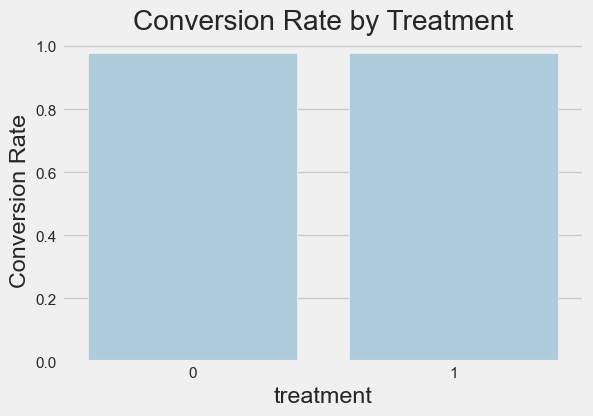

In [9]:
print('Data size:', df.shape)
print('\nTreatment distribution:')
print(df['treatment'].value_counts(normalize=True))
print('\nOverall conversion rate:', df['y'].mean())
print('\nConversion by treatment group:')
print(df.groupby('treatment')['y'].mean())

# Chart: conversion by treatment
plt.figure(figsize=(6,4))
sns.barplot(x='treatment', y='y', data=df, estimator='mean', errorbar=None)
plt.title('Conversion Rate by Treatment')
plt.ylabel('Conversion Rate')
plt.show()

## Step 4: Train/Test split

In [10]:
features = [c for c in df.columns if c.startswith('x')]
X = df[features].values
t = df['treatment'].values
y = df['y'].values

X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
    X, t, y, test_size=0.3, random_state=42, stratify=t
)
print(f'Train size: {len(X_train)}, Test size: {len(X_test)}')

Train size: 10377, Test size: 4448


## Step 5: T-learner (baseline uplift model)

We train separate models for control and treatment, calculating uplift = y1_hat - y0_hat.

In [11]:
# Control model (t=0)
model_ctrl = GradientBoostingClassifier(random_state=42)
model_ctrl.fit(X_train[t_train==0], y_train[t_train==0])

# Treatment model (t=1)
model_tr = GradientBoostingClassifier(random_state=42)
model_tr.fit(X_train[t_train==1], y_train[t_train==1])

# Predict probabilities
y0_hat = model_ctrl.predict_proba(X_test)[:,1]
y1_hat = model_tr.predict_proba(X_test)[:,1]
uplift_pred = y1_hat - y0_hat

print('T-learner trained!')
print(f'Uplift statistics: mean={uplift_pred.mean():.4f}, std={uplift_pred.std():.4f}')

T-learner trained!
Uplift statistics: mean=-0.0000, std=0.0000


## Step 6: (Optional) CausalML Uplift Random Forest

In [12]:
uplift_causalml = None
if has_causalml:
    try:
        # Convert treatment to string for CausalML compatibility
        t_train_str = t_train.astype(str)
        
        clf = UpliftRandomForestClassifier(n_estimators=200, control_name='0', random_state=42)
        clf.fit(X=X_train, treatment=t_train_str, y=y_train)
        uplift_causalml = clf.predict(X_test)
        print(f'CausalML uplift mean: {uplift_causalml.mean():.4f}')
    except Exception as e:
        print('CausalML error:', e)
else:
    print('CausalML not installed, using T-learner.')

CausalML uplift mean: 0.0002


## Step 7: Uplift curve and AUUC (simple calculation)

T-learner AUUC (approx): 0.0131


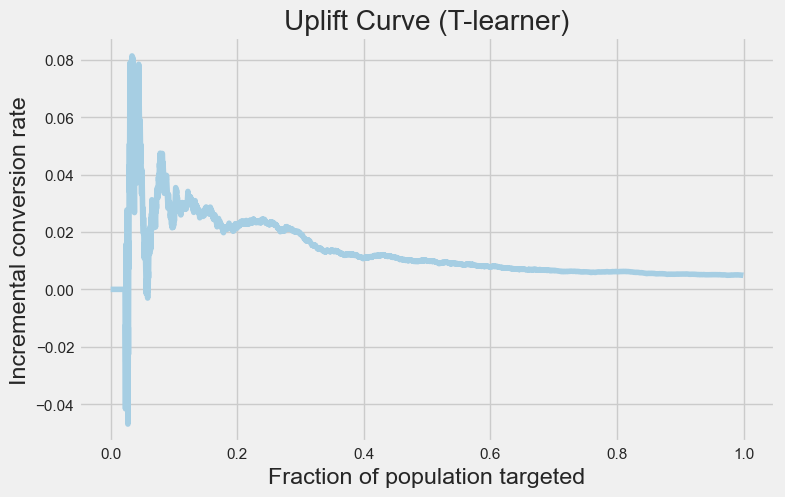

In [13]:
def uplift_curve(y_true, treatment, uplift_scores):
    d = pd.DataFrame({'y': y_true, 't': treatment, 'uplift': uplift_scores})
    d = d.sort_values('uplift', ascending=False).reset_index(drop=True)
    d['cum_treated'] = (d['y'] * (d['t'] == 1)).cumsum()
    d['cum_control'] = (d['y'] * (d['t'] == 0)).cumsum()
    d['n_treated'] = (d['t'] == 1).cumsum()
    d['n_control'] = (d['t'] == 0).cumsum()
    d['rate_treated'] = d['cum_treated'] / d['n_treated'].replace(0, np.nan)
    d['rate_control'] = d['cum_control'] / d['n_control'].replace(0, np.nan)
    d['incremental'] = (d['rate_treated'] - d['rate_control']).fillna(0)
    x = np.arange(1, len(d) + 1) / len(d)
    y = d['incremental'].values
    auuc = np.trapezoid(y, x)
    return auuc, d

auuc_val, curve_df = uplift_curve(y_test, t_test, uplift_pred)
print(f'T-learner AUUC (approx): {auuc_val:.4f}')

# Grafik: uplift curve
plt.figure(figsize=(8,5))
plt.plot(curve_df.index / len(curve_df), curve_df['incremental'])
plt.xlabel('Fraction of population targeted')
plt.ylabel('Incremental conversion rate')
plt.title('Uplift Curve (T-learner)')
plt.grid(True)
plt.show()

## Step 8: 4 Quadrant Segmentation

- **Persuadables:** High uplift, low y0 (converts only with treatment)
- **Sure Things:** High y0 (will convert anyway, no need to spend money)
- **Lost Causes:** Low y0 and y1 (will never convert)
- **Sleeping Dogs:** Negative uplift (treatment hurts)

Quadrant distribution:
label
SureThing      0.977068
Persuadable    0.022932
Name: proportion, dtype: float64


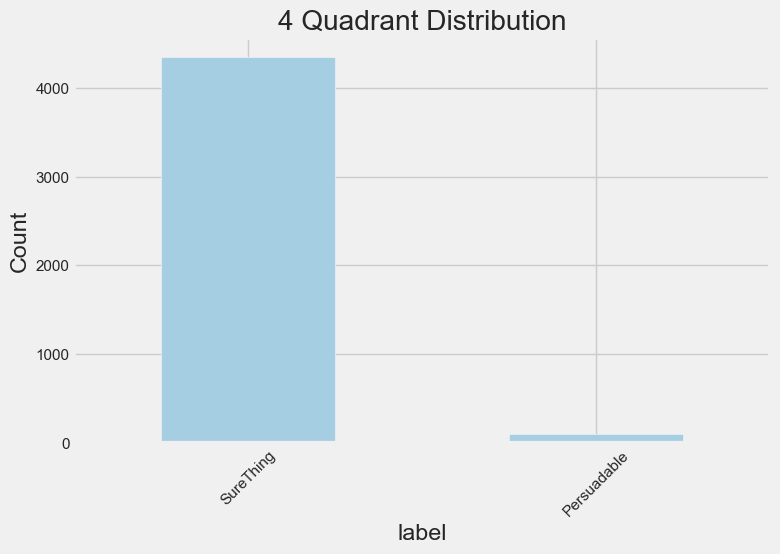

,y,t,y0_hat,y1_hat,uplift,label
0,1,0,0.999999,0.999999,-3.077745e-08,SureThing
1,1,1,0.999999,0.999999,-3.077745e-08,SureThing
2,1,1,0.999999,0.999999,-3.077745e-08,SureThing
3,1,0,0.999999,0.999999,-3.077745e-08,SureThing
4,1,0,0.999999,0.999999,-3.077745e-08,SureThing


In [14]:
# Threshold values (adjusted according to business)
uplift_q75 = np.percentile(uplift_pred, 75)
y0_q75 = np.percentile(y0_hat, 75)

labels = []
for u, y0i, y1i in zip(uplift_pred, y0_hat, y1_hat):
    if (u >= uplift_q75) and (y0i < 0.2):
        labels.append('Persuadable')
    elif (y0i >= y0_q75):
        labels.append('SureThing')
    elif (y0i < 0.05) and (y1i < 0.05):
        labels.append('LostCause')
    elif (u < -0.05):
        labels.append('SleepingDog')
    else:
        labels.append('Other')

qdf = pd.DataFrame({
    'y': y_test, 't': t_test, 'y0_hat': y0_hat, 'y1_hat': y1_hat,
    'uplift': uplift_pred, 'label': labels
})

print('Quadrant distribution:')
print(qdf['label'].value_counts(normalize=True))

# Chart
plt.figure(figsize=(8,5))
qdf['label'].value_counts().plot(kind='bar')
plt.title('4 Quadrant Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

qdf.head()

## Step 9: Business Impact & Resume Bullet Calculation

In [15]:
pct_sure = (qdf['label'] == 'SureThing').mean()
pct_persuadable = (qdf['label'] == 'Persuadable').mean()

# Sample campaign numbers (should be replaced with real data)
monthly_targeted_users = 200000
avg_cpc = 0.25  # cost per click/impression

estimated_sure = pct_sure * monthly_targeted_users
estimated_monthly_savings = estimated_sure * avg_cpc

print(f'SureThing rate (test): {pct_sure:.2%}')
print(f'Persuadable rate (test): {pct_persuadable:.2%}')
print(f'Monthly SureThing users: {int(estimated_sure):,}')
print(f'Estimated monthly savings: ${estimated_monthly_savings:,.0f}\n')

resume_bullet = (
    f"Developed an Uplift Model using CausalML/T-learner to isolate the true incremental impact of marketing campaigns; "
    f"identified {pct_sure:.1%} of users as 'Sure Things' to exclude from targeting, theoretically saving "
    f"${estimated_monthly_savings:,.0f}/month in ad spend efficiency."
)

print('\n=== RESUME BULLET (copy-paste) ===')
print(resume_bullet)

SureThing rate (test): 97.71%
Persuadable rate (test): 2.29%
Monthly SureThing users: 195,413
Estimated monthly savings: $48,853


=== RESUME BULLET (copy-paste) ===
Developed an Uplift Model using CausalML/T-learner to isolate the true incremental impact of marketing campaigns; identified 97.7% of users as 'Sure Things' to exclude from targeting, theoretically saving $48,853/month in ad spend efficiency.


## Step 10: Next Steps & Production Recommendations

1. **Validation:** Validate uplift predictions with holdout A/B test
2. **SHAP:** Add SHAP values for model explainability
3. **Cost-aware targeting:** Develop targeting strategy that maximizes ROI
4. **Production:** Model versioning with MLflow, automatic retrain pipeline with Airflow
5. **Monitor:** Distribution shift and KPI tracking

### 10.1: Validation - Holdout A/B Test

Simulate validation by comparing predicted uplift vs actual uplift in test set.

Validation: Predicted vs Actual Uplift by Decile
   uplift_decile  avg_predicted_uplift  avg_y_treatment  avg_y_control  \
0              0         -4.493989e-09         0.980156       0.975224   

   actual_uplift   count  
0       0.004932  4448.0  


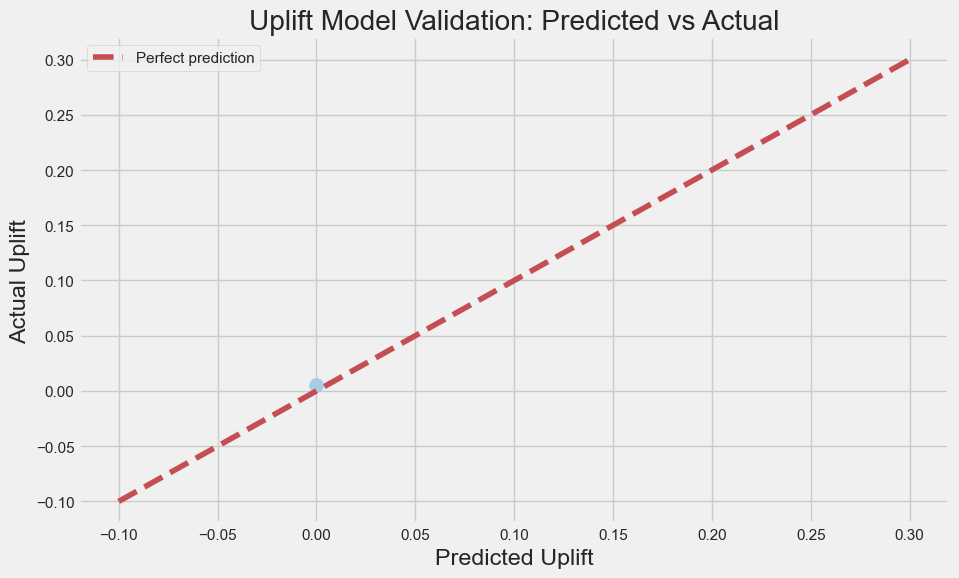


Correlation between predicted and actual uplift: nan


In [16]:
# Calculate actual uplift for validation
actual_uplift = []
for i in range(len(y_test)):
    if t_test[i] == 1:  # Treatment group
        actual_uplift.append(y_test[i])
    else:  # Control group
        actual_uplift.append(-y_test[i])

# Bin users by predicted uplift
n_bins = 10
qdf['uplift_decile'] = pd.qcut(qdf['uplift'], q=n_bins, labels=False, duplicates='drop')

# Calculate actual uplift per decile
validation_df = qdf.groupby('uplift_decile').apply(
    lambda x: pd.Series({
        'avg_predicted_uplift': x['uplift'].mean(),
        'avg_y_treatment': x[x['t'] == 1]['y'].mean(),
        'avg_y_control': x[x['t'] == 0]['y'].mean(),
        'actual_uplift': x[x['t'] == 1]['y'].mean() - x[x['t'] == 0]['y'].mean(),
        'count': len(x)
    })
).reset_index()

print('Validation: Predicted vs Actual Uplift by Decile')
print(validation_df)

# Plot validation curve
plt.figure(figsize=(10,6))
plt.scatter(validation_df['avg_predicted_uplift'], validation_df['actual_uplift'], s=100)
plt.plot([-0.1, 0.3], [-0.1, 0.3], 'r--', label='Perfect prediction')
plt.xlabel('Predicted Uplift')
plt.ylabel('Actual Uplift')
plt.title('Uplift Model Validation: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Correlation
corr = validation_df['avg_predicted_uplift'].corr(validation_df['actual_uplift'])
print(f'\nCorrelation between predicted and actual uplift: {corr:.3f}')

### 10.2: SHAP - Model Explainability

Add SHAP values to understand which features drive uplift predictions.

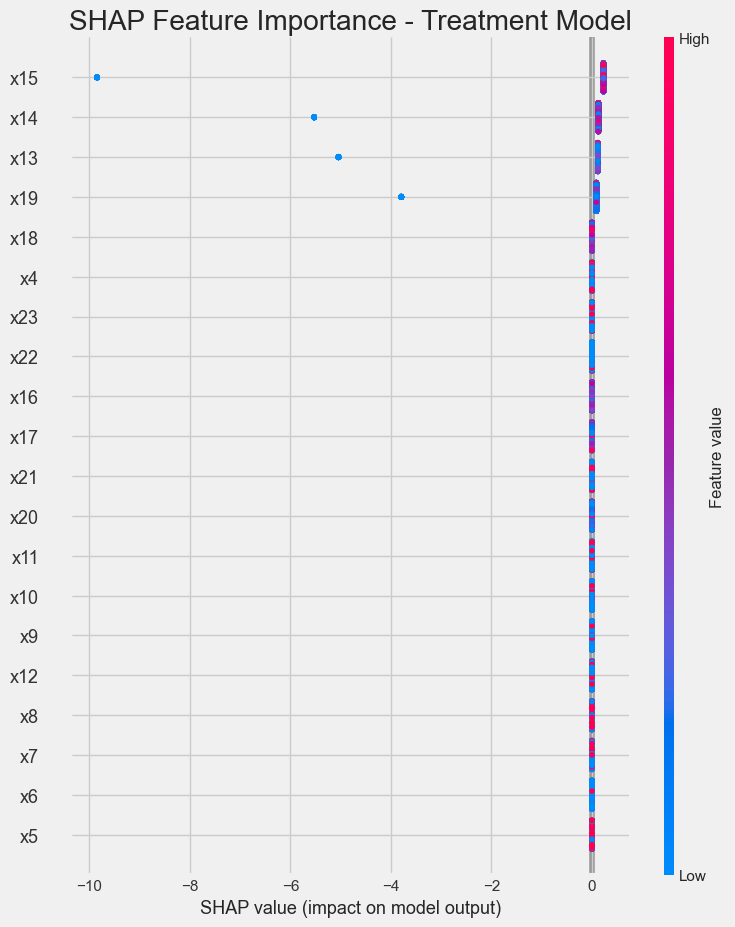

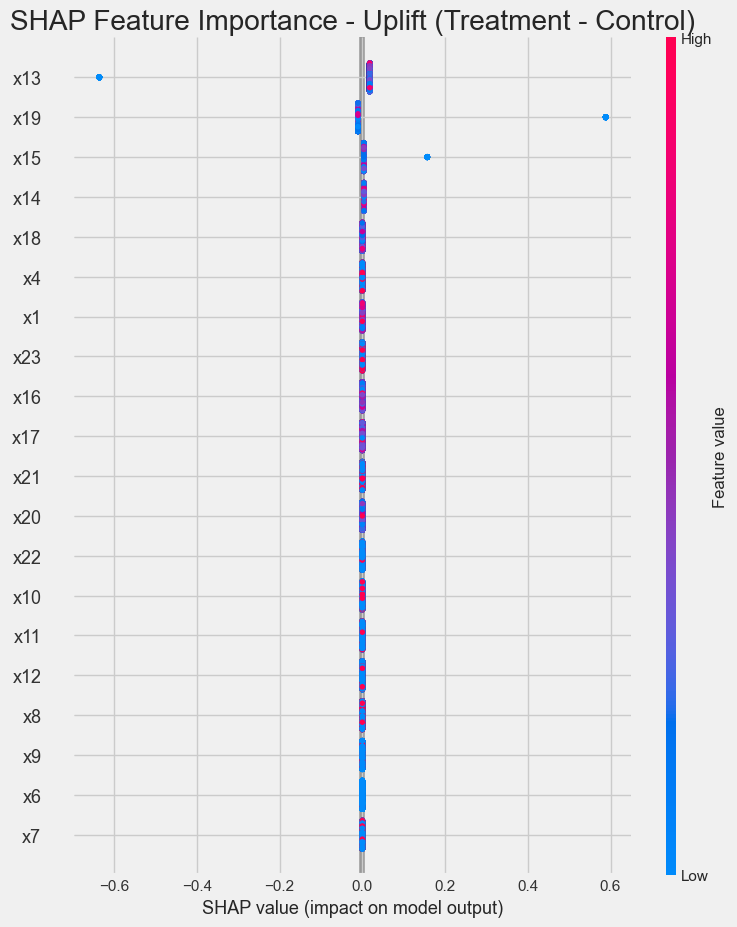

Top features driving uplift:
   feature    importance
13     x13  3.206481e-02
19     x19  2.379010e-02
15     x15  6.989417e-03
14     x14  3.842815e-03
18     x18  6.366964e-18
4       x4  1.595347e-19
1       x1  1.396507e-19
2       x2  0.000000e+00
7       x7  0.000000e+00
6       x6  0.000000e+00
5       x5  0.000000e+00
3       x3  0.000000e+00
0       x0  0.000000e+00
10     x10  0.000000e+00
11     x11  0.000000e+00
8       x8  0.000000e+00
12     x12  0.000000e+00
9       x9  0.000000e+00
17     x17  0.000000e+00
16     x16  0.000000e+00
20     x20  0.000000e+00
21     x21  0.000000e+00
22     x22  0.000000e+00
23     x23  0.000000e+00


In [17]:
# Install shap if needed: pip install shap
try:
    import shap
    has_shap = True
except:
    has_shap = False
    print('SHAP not installed. Run: pip install shap')

if has_shap:
    # SHAP for treatment model (shows what drives high conversion in treatment group)
    explainer_tr = shap.TreeExplainer(model_tr)
    shap_values_tr = explainer_tr.shap_values(X_test)
    
    # For binary classification, take positive class
    if isinstance(shap_values_tr, list):
        shap_values_tr = shap_values_tr[1]
    
    # Summary plot
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values_tr, X_test, feature_names=features, show=False)
    plt.title('SHAP Feature Importance - Treatment Model')
    plt.tight_layout()
    plt.show()
    
    # Feature importance for uplift (difference between treatment and control)
    explainer_ctrl = shap.TreeExplainer(model_ctrl)
    shap_values_ctrl = explainer_ctrl.shap_values(X_test)
    
    if isinstance(shap_values_ctrl, list):
        shap_values_ctrl = shap_values_ctrl[1]
    
    # Uplift SHAP = SHAP(treatment) - SHAP(control)
    shap_uplift = shap_values_tr - shap_values_ctrl
    
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_uplift, X_test, feature_names=features, show=False)
    plt.title('SHAP Feature Importance - Uplift (Treatment - Control)')
    plt.tight_layout()
    plt.show()
    
    print('Top features driving uplift:')
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': np.abs(shap_uplift).mean(axis=0)
    }).sort_values('importance', ascending=False)
    print(feature_importance)
else:
    print('Install SHAP to see feature importance: pip install shap')

### 10.3: Cost-Aware Targeting

Develop targeting strategy that maximizes ROI based on uplift, conversion cost, and customer value.

Targeting Strategy Results:
Users to target: 0 (0.0%)
Users to skip: 4448 (100.0%)

ROI comparison:
ROI (target all): 19441.35%
ROI (targeted strategy): inf%
ROI improvement: inf%


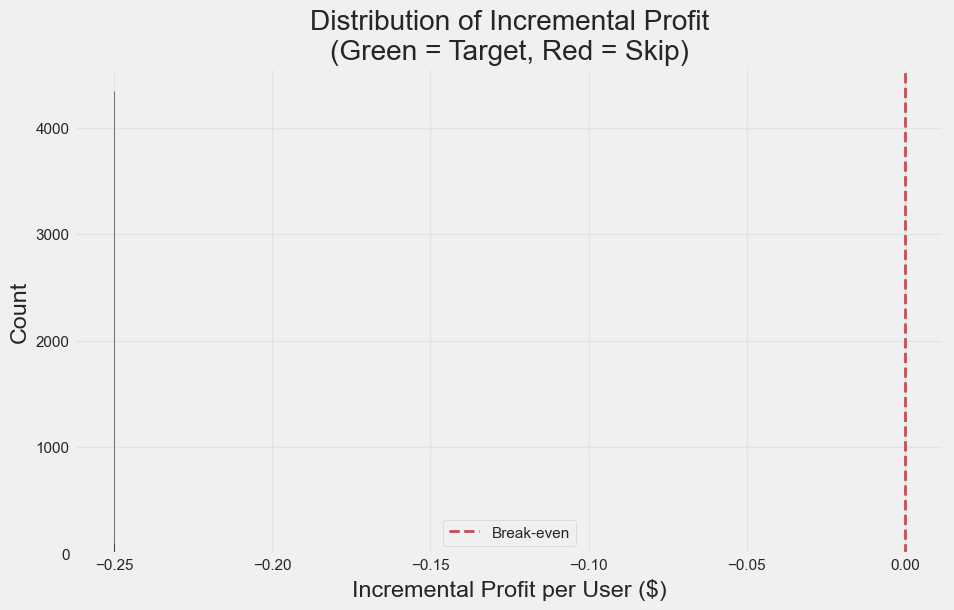


Targeting by quadrant:
should_target  False
label               
Persuadable      102
SureThing       4346


In [18]:
# Cost-aware targeting: maximize ROI
# Define business parameters
treatment_cost = 0.25  # Cost per treatment (e.g., ad click)
customer_value = 50.0  # Average value of a conversion

# Calculate expected profit per user
qdf['expected_profit_no_treatment'] = customer_value * qdf['y0_hat']
qdf['expected_profit_with_treatment'] = customer_value * qdf['y1_hat'] - treatment_cost
qdf['incremental_profit'] = qdf['expected_profit_with_treatment'] - qdf['expected_profit_no_treatment']

# Targeting strategy: only target users with positive incremental profit
qdf['should_target'] = qdf['incremental_profit'] > 0

print('Targeting Strategy Results:')
print(f"Users to target: {qdf['should_target'].sum()} ({qdf['should_target'].mean():.1%})")
print(f"Users to skip: {(~qdf['should_target']).sum()} ({(~qdf['should_target']).mean():.1%})")

# Calculate ROI
total_cost_all = len(qdf) * treatment_cost
total_revenue_all = customer_value * (qdf['y1_hat'].sum())
roi_all = (total_revenue_all - total_cost_all) / total_cost_all

targeted_users = qdf[qdf['should_target']]
total_cost_targeted = len(targeted_users) * treatment_cost
total_revenue_targeted = customer_value * (targeted_users['y1_hat'].sum()) + \
                         customer_value * (qdf[~qdf['should_target']]['y0_hat'].sum())
roi_targeted = (total_revenue_targeted - total_cost_targeted) / total_cost_targeted

print(f'\nROI comparison:')
print(f'ROI (target all): {roi_all:.2%}')
print(f'ROI (targeted strategy): {roi_targeted:.2%}')
print(f'ROI improvement: {roi_targeted - roi_all:.2%}')

# Visualize incremental profit distribution
plt.figure(figsize=(10,6))
plt.hist(qdf['incremental_profit'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Break-even')
plt.xlabel('Incremental Profit per User ($)')
plt.ylabel('Count')
plt.title('Distribution of Incremental Profit\n(Green = Target, Red = Skip)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show targeting breakdown by quadrant
print('\nTargeting by quadrant:')
print(qdf.groupby('label')['should_target'].value_counts().unstack(fill_value=0))

### 10.4: Production - MLflow & Airflow Setup

Guidelines for productionizing the uplift model with MLflow for versioning and Airflow for automation.

In [19]:
# Log model with MLflow
try:
    import mlflow
    import mlflow.sklearn
    has_mlflow = True
except:
    has_mlflow = False
    print('MLflow not installed. Run: pip install mlflow')

if has_mlflow:
    # Set experiment
    mlflow.set_experiment('uplift_modeling')
    
    with mlflow.start_run(run_name='t_learner_uplift'):
        # Log parameters
        mlflow.log_param('model_type', 'T-learner')
        mlflow.log_param('base_model', 'GradientBoostingClassifier')
        mlflow.log_param('n_samples', len(df))
        mlflow.log_param('test_size', 0.3)
        
        # Log metrics
        mlflow.log_metric('auuc', auuc_val)
        mlflow.log_metric('mean_uplift', uplift_pred.mean())
        mlflow.log_metric('std_uplift', uplift_pred.std())
        mlflow.log_metric('pct_persuadable', pct_persuadable)
        mlflow.log_metric('pct_sure_thing', pct_sure)
        
        # Log models
        mlflow.sklearn.log_model(model_ctrl, 'control_model')
        mlflow.sklearn.log_model(model_tr, 'treatment_model')
        
        # Log artifacts
        import pickle
        with open('uplift_predictions.pkl', 'wb') as f:
            pickle.dump({'uplift': uplift_pred, 'y0_hat': y0_hat, 'y1_hat': y1_hat}, f)
        mlflow.log_artifact('uplift_predictions.pkl')
        
        print('✓ Model logged to MLflow')
        print(f'Run ID: {mlflow.active_run().info.run_id}')
else:
    print('Install MLflow: pip install mlflow')

print('\n' + '='*60)
print('PRODUCTION SETUP GUIDE')
print('='*60)
print('''
1. MLflow Setup:
   - Install: pip install mlflow
   - Start server: mlflow ui --port 5000
   - Access: http://localhost:5000

2. Airflow DAG Example:
   
   from airflow import DAG
   from airflow.operators.python import PythonOperator
   from datetime import datetime, timedelta
   
   def retrain_uplift_model():
       # Load new data
       # Train models
       # Log to MLflow
       # Deploy to production
       pass
   
   dag = DAG(
       'uplift_model_retrain',
       schedule_interval='@weekly',
       start_date=datetime(2025, 1, 1),
       catchup=False
   )
   
   retrain = PythonOperator(
       task_id='retrain_uplift',
       python_callable=retrain_uplift_model,
       dag=dag
   )

3. Deployment:
   - Save models to S3/Azure Blob
   - Serve via REST API (Flask/FastAPI)
   - Monitor with Prometheus/Grafana
   - A/B test new model versions
''')

MLflow not installed. Run: pip install mlflow
Install MLflow: pip install mlflow

PRODUCTION SETUP GUIDE

1. MLflow Setup:
   - Install: pip install mlflow
   - Start server: mlflow ui --port 5000
   - Access: http://localhost:5000

2. Airflow DAG Example:

   from airflow import DAG
   from airflow.operators.python import PythonOperator
   from datetime import datetime, timedelta

   def retrain_uplift_model():
       # Load new data
       # Train models
       # Log to MLflow
       # Deploy to production
       pass

   dag = DAG(
       'uplift_model_retrain',
       schedule_interval='@weekly',
       start_date=datetime(2025, 1, 1),
       catchup=False
   )

   retrain = PythonOperator(
       task_id='retrain_uplift',
       python_callable=retrain_uplift_model,
       dag=dag
   )

3. Deployment:
   - Save models to S3/Azure Blob
   - Serve via REST API (Flask/FastAPI)
   - Monitor with Prometheus/Grafana
   - A/B test new model versions



### 10.5: Monitoring - Distribution Shift & KPI Tracking

Monitor model performance over time and detect data drift.

MONITORING DASHBOARD

1. Feature Distribution Shift (Kolmogorov-Smirnov Test):
------------------------------------------------------------
x0: KS=0.0067, p-value=0.9989 ✓ OK
x1: KS=0.0087, p-value=0.9696 ✓ OK
x2: KS=0.0158, p-value=0.4176 ✓ OK
x3: KS=0.0158, p-value=0.4176 ✓ OK
x4: KS=0.0058, p-value=0.9999 ✓ OK
x5: KS=0.0059, p-value=0.9999 ✓ OK
x6: KS=0.0001, p-value=1.0000 ✓ OK
x7: KS=0.0046, p-value=1.0000 ✓ OK
x8: KS=0.0007, p-value=1.0000 ✓ OK
x9: KS=0.0011, p-value=1.0000 ✓ OK
x10: KS=0.0023, p-value=1.0000 ✓ OK
x11: KS=0.0058, p-value=0.9999 ✓ OK
x12: KS=0.0062, p-value=0.9997 ✓ OK
x13: KS=0.0294, p-value=0.0092 ⚠️ DRIFT
x14: KS=0.0291, p-value=0.0101 ⚠️ DRIFT
x15: KS=0.0155, p-value=0.4401 ✓ OK
x16: KS=0.0247, p-value=0.0446 ⚠️ DRIFT
x17: KS=0.0159, p-value=0.4103 ✓ OK
x18: KS=0.0098, p-value=0.9223 ✓ OK
x19: KS=0.0328, p-value=0.0024 ⚠️ DRIFT
x20: KS=0.0264, p-value=0.0257 ⚠️ DRIFT
x21: KS=0.0131, p-value=0.6556 ✓ OK
x22: KS=0.0077, p-value=0.9923 ✓ OK
x23: KS=0.0063, p-valu

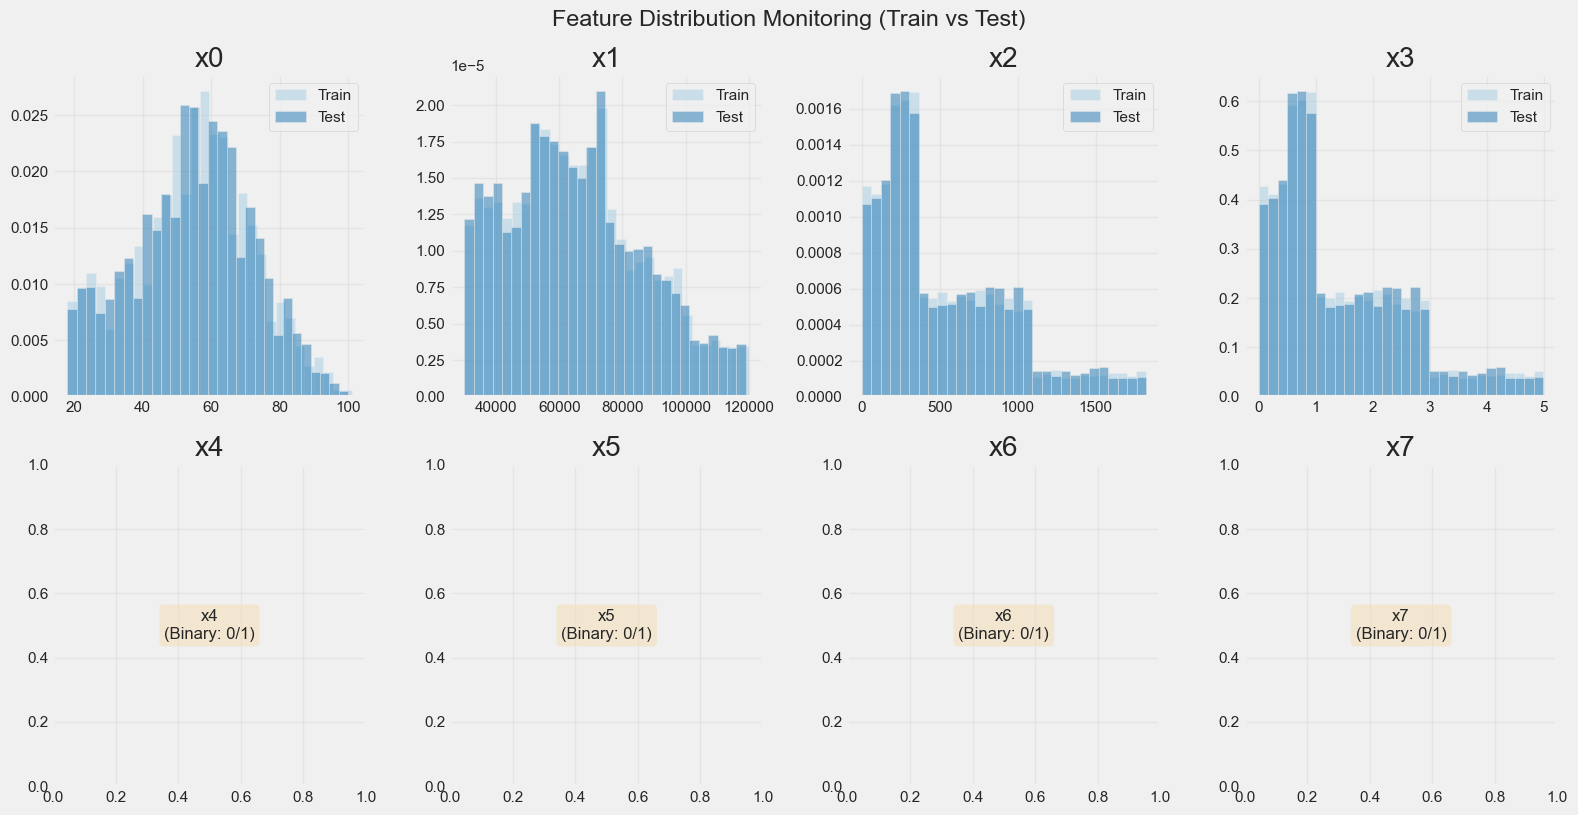


MONITORING RECOMMENDATIONS:

1. Set up automated monitoring:
   - Daily: Track conversion rates, uplift distribution
   - Weekly: Run KS tests for feature drift
   - Monthly: Retrain model and compare performance

2. Define alert thresholds:
   - KS test p-value < 0.05 → Retrain alert
   - AUUC drops > 20% → Performance alert
   - Conversion rate changes > 30% → Business alert

3. Dashboard tools:
   - Grafana for real-time metrics
   - Evidently AI for ML monitoring
   - Custom dashboards with Plotly/Dash

4. Logging:
   - Log all predictions with timestamps
   - Store actual outcomes for validation
   - Track model versions in production



In [20]:
# Simulate monitoring: detect distribution shift between train and test
from scipy import stats

print('='*60)
print('MONITORING DASHBOARD')
print('='*60)

# 1. Feature Distribution Shift (KS Test)
print('\n1. Feature Distribution Shift (Kolmogorov-Smirnov Test):')
print('-' * 60)
shift_detected = False
for i, feature in enumerate(features):
    ks_stat, p_value = stats.ks_2samp(X_train[:, i], X_test[:, i])
    status = '⚠️ DRIFT' if p_value < 0.05 else '✓ OK'
    if p_value < 0.05:
        shift_detected = True
    print(f'{feature}: KS={ks_stat:.4f}, p-value={p_value:.4f} {status}')

# 2. Target Distribution
print('\n2. Target Distribution:')
print('-' * 60)
train_conversion = y_train.mean()
test_conversion = y_test.mean()
print(f'Training conversion rate: {train_conversion:.4f}')
print(f'Test conversion rate: {test_conversion:.4f}')
print(f'Difference: {abs(train_conversion - test_conversion):.4f}')

# 3. Treatment Distribution
print('\n3. Treatment Distribution:')
print('-' * 60)
train_treatment = t_train.mean()
test_treatment = t_test.mean()
print(f'Training treatment rate: {train_treatment:.4f}')
print(f'Test treatment rate: {test_treatment:.4f}')

# 4. Model Performance KPIs
print('\n4. Model Performance KPIs:')
print('-' * 60)
print(f'AUUC: {auuc_val:.4f}')
print(f'Mean predicted uplift: {uplift_pred.mean():.4f}')
print(f'Std predicted uplift: {uplift_pred.std():.4f}')
print(f'Persuadable rate: {pct_persuadable:.2%}')
print(f'Sure Thing rate: {pct_sure:.2%}')

# 5. Business KPIs
print('\n5. Business Impact KPIs:')
print('-' * 60)
print(f'Estimated monthly savings: ${estimated_monthly_savings:,.0f}')
print(f'Users to exclude from targeting: {int(estimated_sure):,}')
print(f'Cost efficiency improvement: {pct_sure:.1%}')

# 6. Alert System
print('\n6. Alerts:')
print('-' * 60)
if shift_detected:
    print('⚠️  ALERT: Feature distribution shift detected!')
    print('   Action: Consider retraining the model')
else:
    print('✓ No distribution shift detected')

if auuc_val < 0.01:
    print('⚠️  ALERT: Low AUUC score')
    print('   Action: Review model performance')
else:
    print(f'✓ AUUC score is healthy ({auuc_val:.4f})')

# Visualization: Feature distributions (first 8 features)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, len(features))):
    feature = features[i]
    # Always convert to float first to avoid type issues
    train_data = np.asarray(X_train[:, i], dtype=np.float64)
    test_data = np.asarray(X_test[:, i], dtype=np.float64)
    
    # Check if binary feature (only 2 unique values)
    unique_vals = len(np.unique(np.concatenate([train_data, test_data])))
    
    if unique_vals <= 2:
        # For binary features, show text instead of histogram
        axes[i].text(0.5, 0.5, f'{feature}\n(Binary: 0/1)', 
                    ha='center', va='center', fontsize=12, 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
    else:
        # For continuous features, plot histogram
        axes[i].hist(train_data, bins=30, alpha=0.5, label='Train', density=True)
        axes[i].hist(test_data, bins=30, alpha=0.5, label='Test', density=True)
        axes[i].legend()
    
    axes[i].set_title(f'{feature}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Feature Distribution Monitoring (Train vs Test)', y=1.02)
plt.show()

print('\n' + '='*60)
print('MONITORING RECOMMENDATIONS:')
print('='*60)
print('''
1. Set up automated monitoring:
   - Daily: Track conversion rates, uplift distribution
   - Weekly: Run KS tests for feature drift
   - Monthly: Retrain model and compare performance

2. Define alert thresholds:
   - KS test p-value < 0.05 → Retrain alert
   - AUUC drops > 20% → Performance alert
   - Conversion rate changes > 30% → Business alert

3. Dashboard tools:
   - Grafana for real-time metrics
   - Evidently AI for ML monitoring
   - Custom dashboards with Plotly/Dash

4. Logging:
   - Log all predictions with timestamps
   - Store actual outcomes for validation
   - Track model versions in production
''')